In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv


In [2]:
!pip install pmdarima
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 728.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9432368 sha256=e9141dc2901724548f07f1af0d38d0ffb34756bc94672a1c1c3b4c64d570ad28
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.


In [3]:
from fbprophet import Prophet
from pmdarima.arima import auto_arima

In [4]:
df = pd.read_csv("../input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


Text(0.5, 1.0, 'History of Microsoft Stock Price')

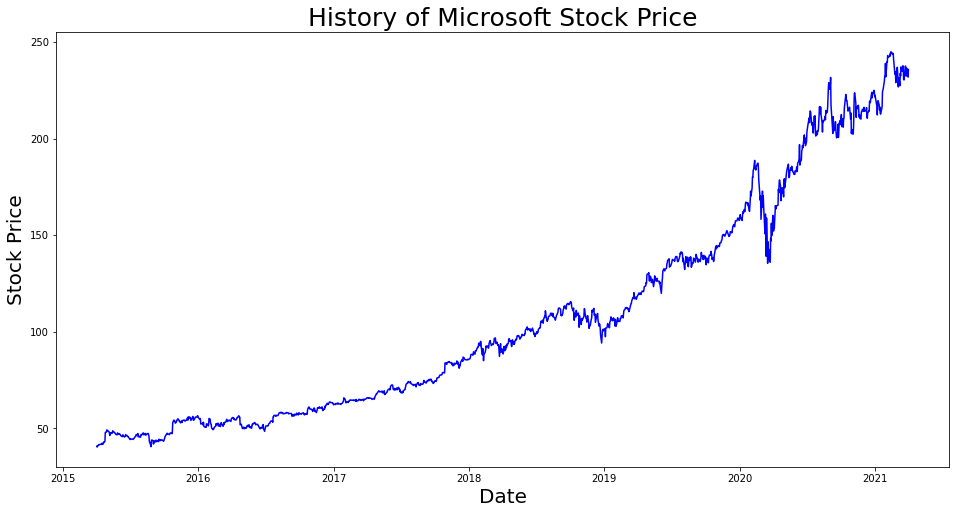

In [6]:
df['Date'] = pd.to_datetime(df.Date, format = '%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize = (16, 8))
plt.plot(df['Close'], label ='Closing Price History', color = 'b' )
plt.xlabel('Date', size = 20)
plt.ylabel('Stock Price', size = 20)
plt.title('History of Microsoft Stock Price', size = 25)

In [7]:
def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['Close'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 76.62376749929759
-----------------------------------------------------------
-----------------------------------------------------------


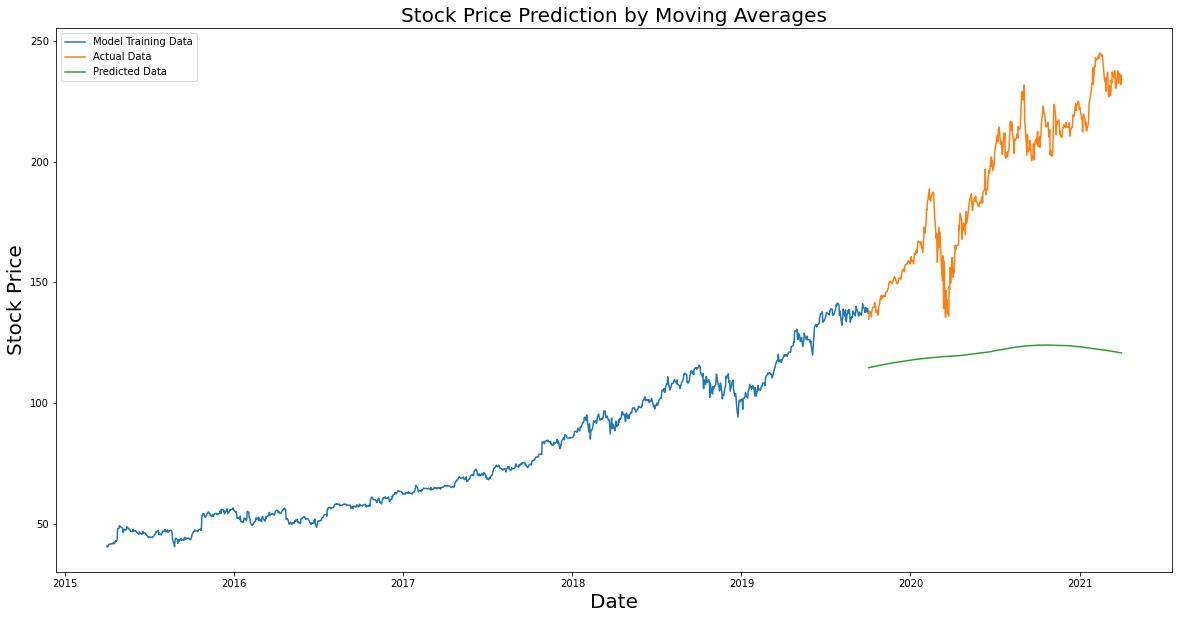

In [8]:
moving_avg_prediction(df)

In [9]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 58.36609230803357
-----------------------------------------------------------
-----------------------------------------------------------


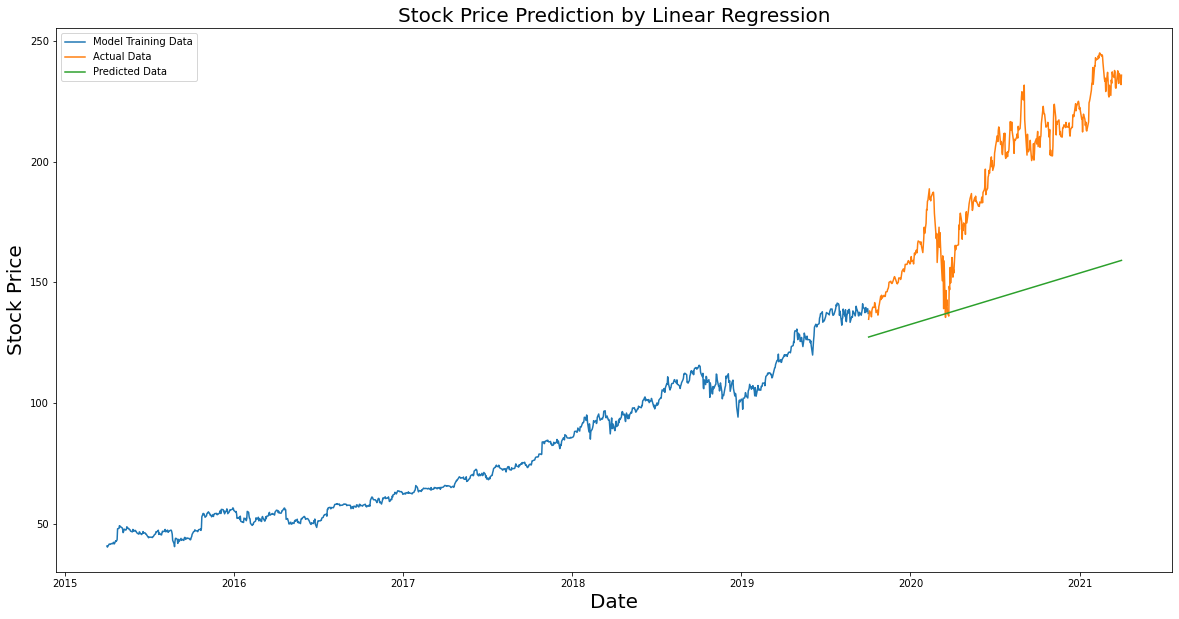

In [10]:
linear_regression_prediction(df)

In [11]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 112.9467566922719
-----------------------------------------------------------
-----------------------------------------------------------


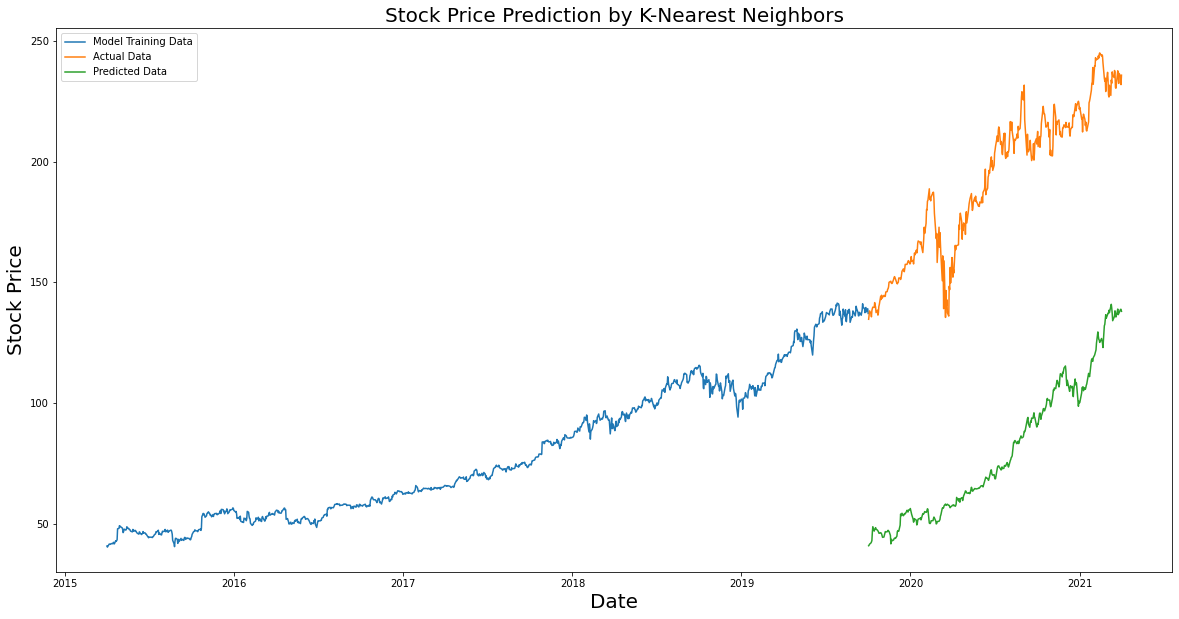

In [12]:
k_nearest_neighbours_predict(df)

In [13]:
def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Close']
    validation = valid_set['Close']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1134, 6)
Shape of Validation Set (377, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4440.431, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4126.393, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4427.420, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3999.903, Time=1.05 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4015.175, Time=1.01 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3983.513, Time=1.46 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4107.542, Time=0.83 se

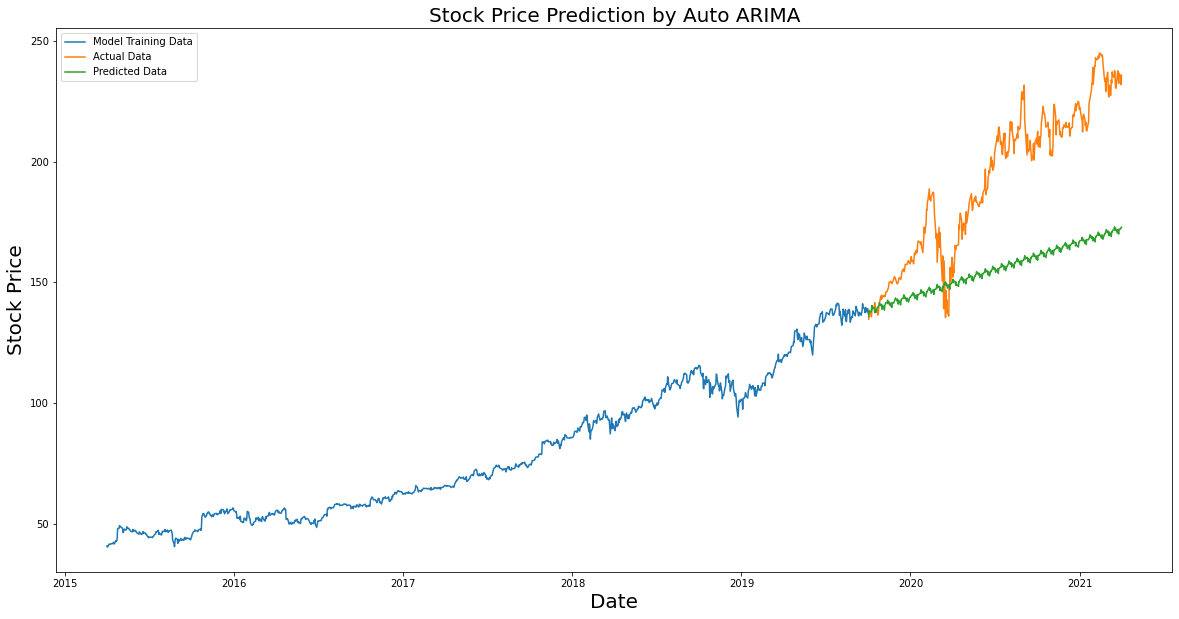

In [14]:
auto_arima_prediction(df)

In [15]:
def fb_prophet_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.reset_index(inplace=True)
    df_new['Date'] = pd.to_datetime(df_new.Date,format='%Y-%m-%d')
    df_new.index = df_new['Date']
    df_new.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY FB PROPHET-----------')
    print('-------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    model = Prophet()
    model.fit(train_set)
    close_prices = model.make_future_dataframe(periods=len(valid_set))
    forecast = model.predict(close_prices)
    forecast_valid = forecast['yhat'][ceil(shape*0.75):]
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['y'])-np.array(forecast_valid)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = forecast_valid.values
    plt.plot(train_set['y'])
    plt.plot(valid_set[['y', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by FB Prophet',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------
-----------STOCK PRICE PREDICTION BY FB PROPHET-----------
-------------------------------------------------------
Shape of Training Set (1134, 2)
Shape of Validation Set (377, 2)
Initial log joint probability = -6.02459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3616.84    0.00258209       573.589           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3664.28    0.00193875       490.995           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3697.91     0.0163744        3506.1      0.4285           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3746.19      0.004461       712.655      0.2774           1      491   
    Ite

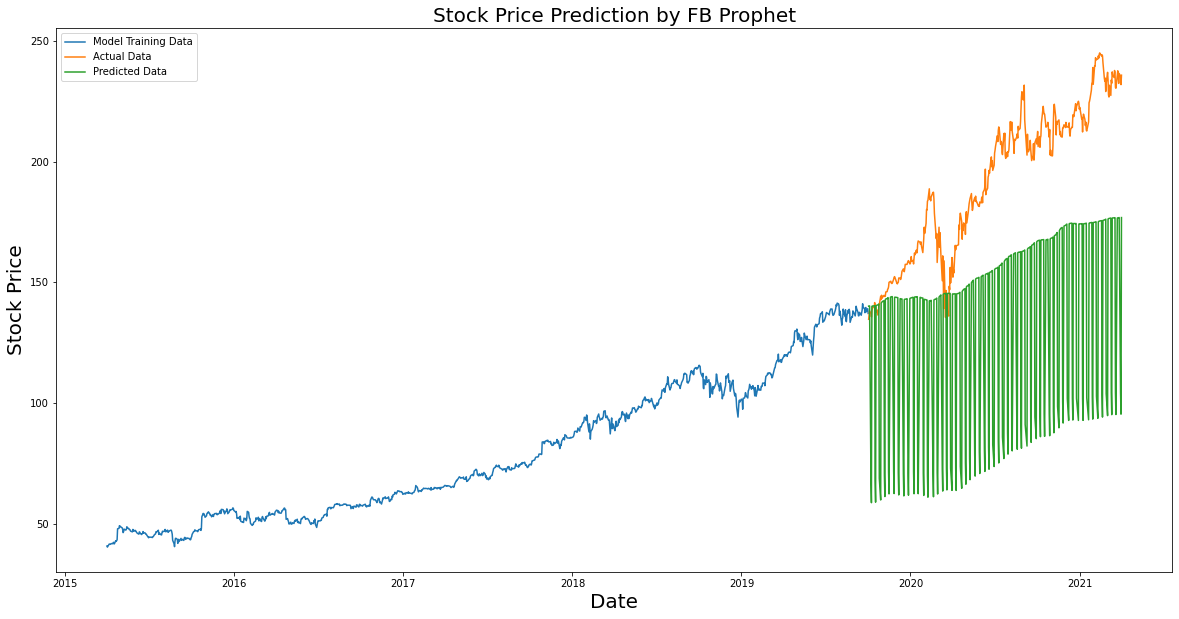

In [16]:
fb_prophet_prediction(df)

In [17]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)


2022-07-26 18:16:16.718069: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-26 18:16:17.359732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1094/1094 - 25s - loss: 7.2267e-04
RMSE value on validation set: Close    11.711357
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


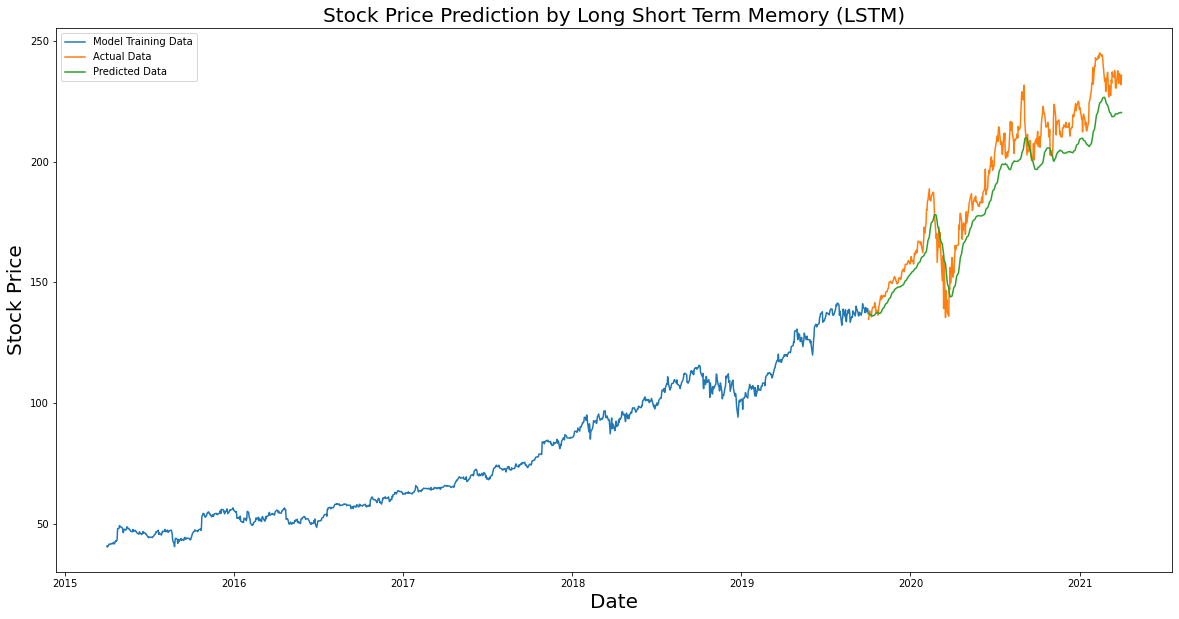

In [18]:
lstm_prediction(df)